In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings

# 특정 FutureWarning 메시지를 무시하도록 설정
warnings.filterwarnings(
    action='ignore', # 경고를 무시함
    message="Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated", # 정확한 경고 메시지 문자열
    category=FutureWarning, # FutureWarning 카테고리
)
# clip, where, mask 관련 FutureWarning 메시지를 무시하도록 설정
warnings.filterwarnings(
    action='ignore',
    message="Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated.", # 정확한 경고 메시지
    category=FutureWarning
)

# Load the Dataset

In [73]:
dataset = pd.read_excel('final_dataset.xlsx')

# 결측치 처리

### - 해당 데이터셋은 국가 통계 포털인 KOSIS로부터 가져온 데이터이기 때문에 결측치가 존재하지 않음
### - 따라서 결측치를 무작위로 생성

In [74]:
# 원본 데이터를 보존
df_nan = dataset.copy()

# 항상 같은 결과가 나오도록 시드를 고정
np.random.seed(42)
# 결측치 비율을 전체 데이터의 1%로 설정
missing_rate = 0.01

# 전체 셀 개수 계산
tot_cells = df_nan.size
num_missing = int(tot_cells * missing_rate)


# 무작위 (행, 열) 인덱스 생성
rows = np.random.randint(0, df_nan.shape[0], num_missing)
cols = np.random.randint(0, df_nan.shape[1], num_missing)

# 무작위 위치에 결측치 삽입
for row, col in zip(rows, cols):
    df_nan.iat[row, col] = np.nan

# 각 열마다 결측치의 개수 세어주는 코드.
print(df_nan.isnull().sum())

조사연월                       112
가구구분코드                     121
가구원수                       132
취업인원수                      137
노인가구여부                     122
가구주_연령                     131
가구주_학력코드                   112
가구주_취업여부                   140
가구주_10차산업분류코드              118
거처구분코드                     128
입주형태코드                     143
전국전체가구_1인이상소득10분위코드        129
소득구간코드                     162
가계지출금액                     116
가계지출_소비지출금액                154
가계지출_소비지출_식료품비주류음료구입비      126
가계지출_소비지출_주류담배구입비          162
가계지출_소비지출_의류신발구입비          119
가계지출_소비지출_주거수도광열비          132
가계지출_소비지출_가정용품가사서비스이용금액    131
가계지출_소비지출_보건제품구입비          124
가계지출_소비지출_교통비              165
가계지출_소비지출_통신비              143
가계지출_소비지출_오락문화비            124
가계지출_소비지출_교육비              136
가계지출_소비지출_음식숙박비            139
가계지출_소비지출_기타상품서비스이용금액      149
도시읍면부구분코드                  142
dtype: int64


### - 각 열마다 결측치를 처리
### - 이미 완벽하게 정렬된 데이터이기 때문에 결측치를 바로 앞의 행 값으로 처리

In [75]:
# Nan 값을 모두 처리한 이후의 데이터를 저장할 df를 생성

df_full = df_nan.copy()

# 조사연월은 다른 행의 값과 똑같이 처리(202400으로)
df_full['조사연월'] = df_nan['조사연월'].fillna(202400)

# 가구구분코드 
df_full['가구구분코드'] = df_nan['가구구분코드'].ffill()

# 가구원수
df_full['가구원수'] = df_nan['가구원수'].ffill()

# 취업인원수
df_full['취업인원수'] = df_nan['취업인원수'].ffill()

# 가구주연령 (노인가구여부 다음 열이긴 하지만 이걸 먼저 채워야 노인가구여부를 채울 수 있음)
df_full['가구주_연령'] = df_nan['가구주_연령'].ffill()

# 노인가구여부 가구주_연령이 65세 이상인 경우 노인가구여부를 1로 설정
df_full.loc[df_nan['가구주_연령'] >= 65, '노인가구여부'] = 1
# 나머지 NaN인 노인가구여부는 0으로 채움
df_full['노인가구여부'] = df_nan['노인가구여부'].fillna(0)

# 가구주_학력코드
df_full['가구주_학력코드'] = df_nan['가구주_학력코드'].ffill()

# 가구주_취업여부
df_full['가구주_취업여부'] = df_nan['가구주_취업여부'].ffill()

# 가구주_10차산업분류코드
df_full['가구주_10차산업분류코드'] = df_nan['가구주_10차산업분류코드'].ffill()

# 거처구분코드
df_full['거처구분코드'] = df_nan['거처구분코드'].ffill()

# 입주형태코드
df_full['입주형태코드'] = df_nan['입주형태코드'].ffill()

# 12개의 소비품목, 가계지출_소비지출금액 결측치 채워넣기
# 소비지출 항목 12개
item_columns = [
    '가계지출_소비지출_식료품비주류음료구입비',
    '가계지출_소비지출_주류담배구입비',
    '가계지출_소비지출_의류신발구입비',
    '가계지출_소비지출_주거수도광열비',
    '가계지출_소비지출_가정용품가사서비스이용금액',
    '가계지출_소비지출_보건제품구입비',
    '가계지출_소비지출_교통비',
    '가계지출_소비지출_통신비',
    '가계지출_소비지출_오락문화비',
    '가계지출_소비지출_교육비',
    '가계지출_소비지출_음식숙박비',
    '가계지출_소비지출_기타상품서비스이용금액'
]

total_column = '가계지출_소비지출금액'

# 평균값들 미리 계산
group_item_mean = df_full.groupby('가구원수')[item_columns].mean()
global_item_mean = df_full[item_columns].mean()

def smart_fill(row):
    items = row[item_columns]
    total = row[total_column]
    size = row['가구원수']

    # 1. 총합이 있고, 일부 항목만 결측 → 남은 금액 균등 분배
    if pd.notna(total) and items.isna().any() and items.notna().sum() > 0:
        known_sum = items.sum(skipna=True)
        remaining = total - known_sum
        missing_count = items.isna().sum()
        if missing_count > 0:
            if remaining < 0:
                each = 0
            else:
                each = remaining / missing_count
            each = max(0, each)
            filled_items = items.fillna(each)
            for col_name, val in filled_items.items():
                row[col_name] = val

    # 2. 총합이 결측이고, 항목이 모두 채워짐 → 항목 합으로 총합 계산
    elif pd.isna(total) and items.notna().all():
        row[total_column] = items.sum()

    # 3. 총합과 항목 일부가 모두 결측 → 항목은 그룹 평균으로 채우고 총합은 항목합
    elif pd.isna(total) and items.isna().any():
        if size in group_item_mean.index:
            group_mean_for_size = group_item_mean.loc[size]
            # items.fillna(group_mean_for_size)는 items의 NaN을 group_mean_for_size 값으로 채움
            # 그 결과에 다시 global_item_mean으로 채움
            filled_items = items.fillna(group_mean_for_size).fillna(global_item_mean)
        else:
            filled_items = items.fillna(global_item_mean)
        row[item_columns] = filled_items.infer_objects(copy=False)
        row[total_column] = row[item_columns].sum()

    # 4. 총합은 있지만 항목이 전부 NaN → 12개 항목에 균등 분배
    elif pd.notna(total) and items.isna().all():
        if len(item_columns) > 0: # 혹시 모를 ZeroDivisionError 방지
            value_to_fill = total / len(item_columns)
            # items.index를 사용하여 채워질 Series의 인덱스를 명확히 함
            filled_items = pd.Series([value_to_fill] * len(item_columns), index=items.index)
            row[item_columns] = filled_items.infer_objects(copy=False)

    return row

# 적용
df_full = df_full.apply(smart_fill, axis=1)

In [76]:
df_full.isna().sum()

조사연월                         0
가구구분코드                       0
가구원수                         0
취업인원수                        0
노인가구여부                       0
가구주_연령                       0
가구주_학력코드                     0
가구주_취업여부                     0
가구주_10차산업분류코드                0
거처구분코드                       0
입주형태코드                       0
전국전체가구_1인이상소득10분위코드        129
소득구간코드                     162
가계지출금액                     116
가계지출_소비지출금액                  0
가계지출_소비지출_식료품비주류음료구입비        0
가계지출_소비지출_주류담배구입비            0
가계지출_소비지출_의류신발구입비            0
가계지출_소비지출_주거수도광열비            0
가계지출_소비지출_가정용품가사서비스이용금액      0
가계지출_소비지출_보건제품구입비            0
가계지출_소비지출_교통비                0
가계지출_소비지출_통신비                0
가계지출_소비지출_오락문화비              0
가계지출_소비지출_교육비                0
가계지출_소비지출_음식숙박비              0
가계지출_소비지출_기타상품서비스이용금액        0
도시읍면부구분코드                  142
dtype: int64

In [77]:
# 가계지출금액 (소비지출 + 비소비지출)
# 1. 소비지출금액이 존재할 경우 → 110%로 보정
def fill_total_expenditure(row):
    if pd.isna(row['가계지출금액']):
        consumption = row['가계지출_소비지출금액']
        size = row['가구원수']

        if pd.notna(consumption):
            # 소비지출에 비소비지출 약간 더한 가정
            return consumption * 1.1

        elif size in df_full.groupby('가구원수')['가계지출금액'].mean():
            return df_full.groupby('가구원수')['가계지출금액'].mean().loc[size]

        else:
            return df_full['가계지출금액'].mean()

    else:
        return row['가계지출금액']

# 적용
df_full['가계지출금액'] = df_full.apply(fill_total_expenditure, axis=1)

In [78]:
# 전국전체가구_1인이상소득10분위코드 (상대적). 다른 feature들 먼저 채우고 나중에 채우기.
# 소득구간코드 (절대적), feature selection 과정에서 drop시킬듯. 다른 feature들 먼저 채우고 나중에 채우기.
# 미리 그룹 평균 계산
group_decile_by_income = df_full.groupby('소득구간코드')['전국전체가구_1인이상소득10분위코드'].mean()
group_income_by_decile = df_full.groupby('전국전체가구_1인이상소득10분위코드')['소득구간코드'].mean()
group_income_by_size = df_full.groupby('가구원수')['소득구간코드'].mean()

# 중앙값 (최후의 fallback)
decile_median = df_full['전국전체가구_1인이상소득10분위코드'].median()
income_median = df_full['소득구간코드'].median()

def fill_income_and_decile(row):
    income = row['소득구간코드']
    decile = row['전국전체가구_1인이상소득10분위코드']
    size = row['가구원수']

    # 1. 소득구간코드가 존재하고 분위가 결측
    if pd.notna(income) and pd.isna(decile):
        if income in group_decile_by_income.index:
            row['전국전체가구_1인이상소득10분위코드'] = round(group_decile_by_income.loc[income])

    # 2. 분위가 존재하고 소득구간이 결측
    elif pd.notna(decile) and pd.isna(income):
        if decile in group_income_by_decile.index:
            row['소득구간코드'] = round(group_income_by_decile.loc[decile])

    # 3. 둘 다 결측
    elif pd.isna(income) and pd.isna(decile):
        # 가구원수 기반으로 소득구간 예측
        if pd.notna(size) and size in group_income_by_size.index:
            row['소득구간코드'] = round(group_income_by_size.loc[size])
        else:
            row['소득구간코드'] = income_median

        # 분위는 보수적으로 중앙값 사용
        row['전국전체가구_1인이상소득10분위코드'] = decile_median

    return row

# 적용
df_full = df_full.apply(fill_income_and_decile, axis=1)

In [79]:
# 도시읍면부구분코드
# 최빈값 계산
mode_city = df_full['도시읍면부구분코드'].mode().iloc[0]
# 결측치 채우기
df_full['도시읍면부구분코드'] = df_full['도시읍면부구분코드'].fillna(mode_city)

# 결측치 처리가 잘 되었는지 확인
print(df_full.isnull().sum())



# EDA 결과와 확인하기 위해 12가지 소비 품목의 max값 각각 출력해보기.
print(df_full[item_columns].max())

조사연월                       0
가구구분코드                     0
가구원수                       0
취업인원수                      0
노인가구여부                     0
가구주_연령                     0
가구주_학력코드                   0
가구주_취업여부                   0
가구주_10차산업분류코드              0
거처구분코드                     0
입주형태코드                     0
전국전체가구_1인이상소득10분위코드        0
소득구간코드                     0
가계지출금액                     0
가계지출_소비지출금액                0
가계지출_소비지출_식료품비주류음료구입비      0
가계지출_소비지출_주류담배구입비          0
가계지출_소비지출_의류신발구입비          0
가계지출_소비지출_주거수도광열비          0
가계지출_소비지출_가정용품가사서비스이용금액    0
가계지출_소비지출_보건제품구입비          0
가계지출_소비지출_교통비              0
가계지출_소비지출_통신비              0
가계지출_소비지출_오락문화비            0
가계지출_소비지출_교육비              0
가계지출_소비지출_음식숙박비            0
가계지출_소비지출_기타상품서비스이용금액      0
도시읍면부구분코드                  0
dtype: int64
가계지출_소비지출_식료품비주류음료구입비       2236470.0
가계지출_소비지출_주류담배구입비            674620.0
가계지출_소비지출_의류신발구입비           3833847.0
가계지출_소비지출_주거수도광열비          26711138.0
가계지출_소비지출_가정용품가사서비스이용금액

# EDA 진행

In [81]:
# EDA - 한글 폰트 설정
# AppleGothic 폰트는 윈도우에서 사용불가
# https://fonts.google.com/noto/specimen/Noto+Sans+KR
# 해당 웹사이트에서 폰트를 다운받아 사용
plt.rcParams['font.family'] = 'Noto Sans KR'
plt.rcParams['axes.unicode_minus'] = False

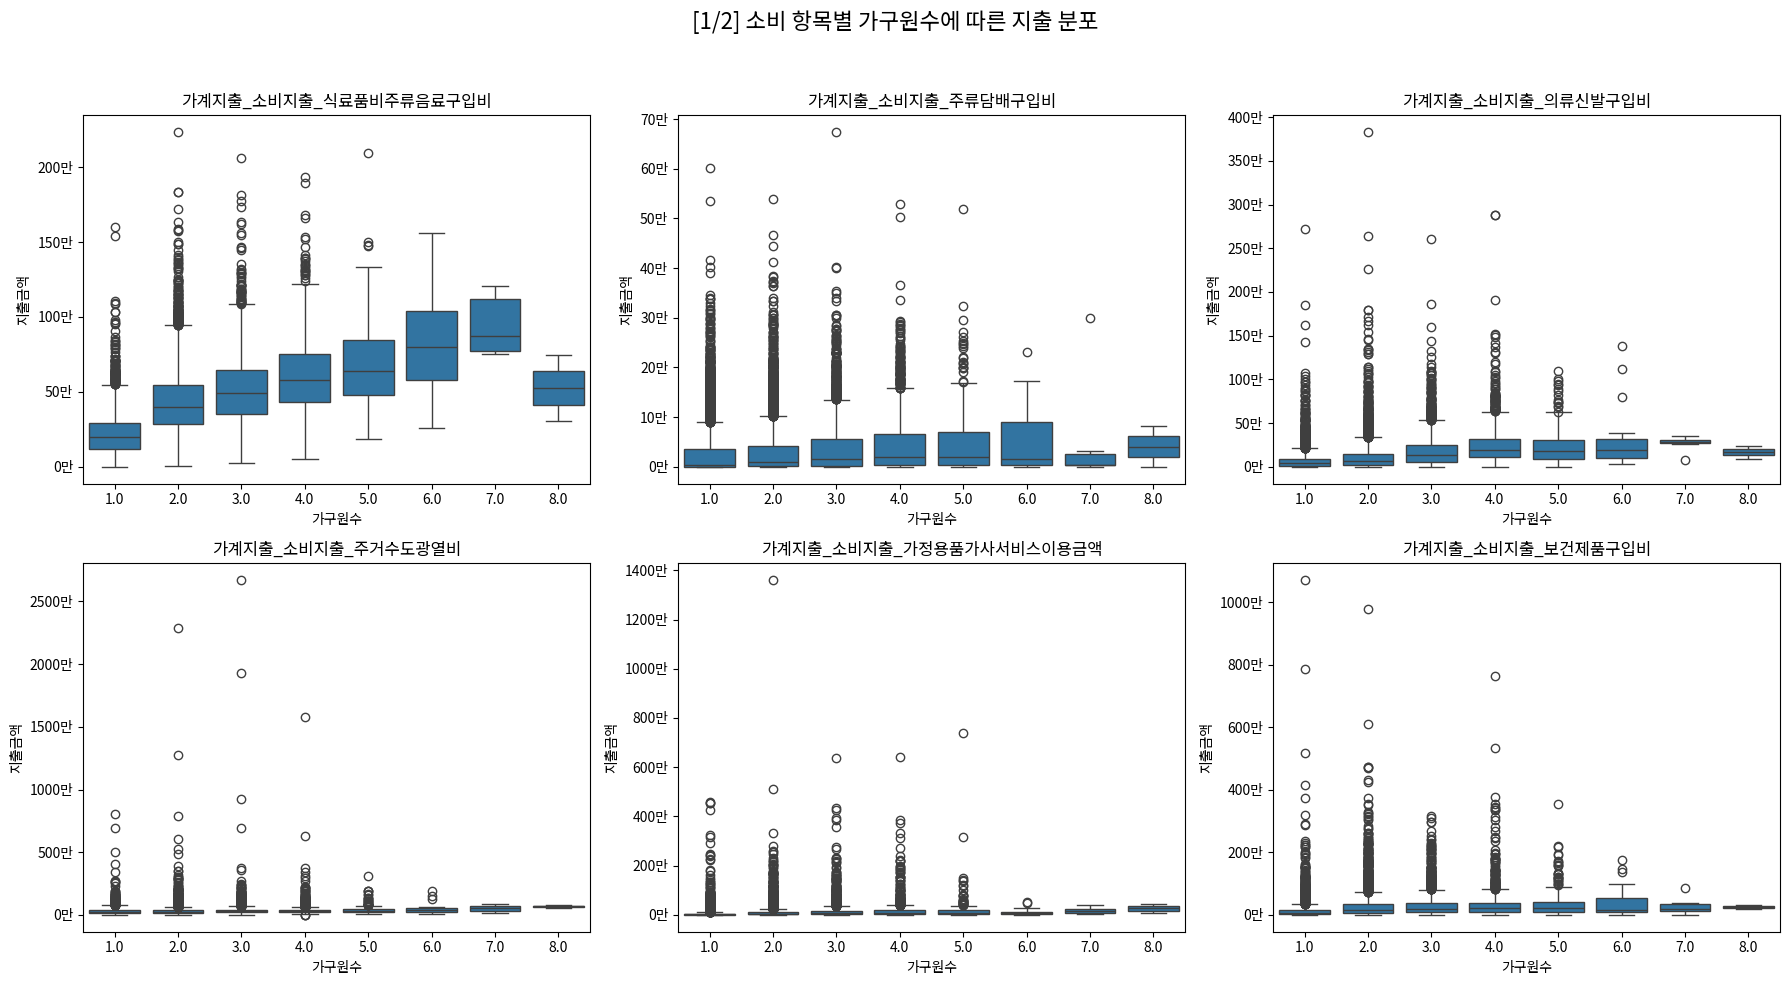

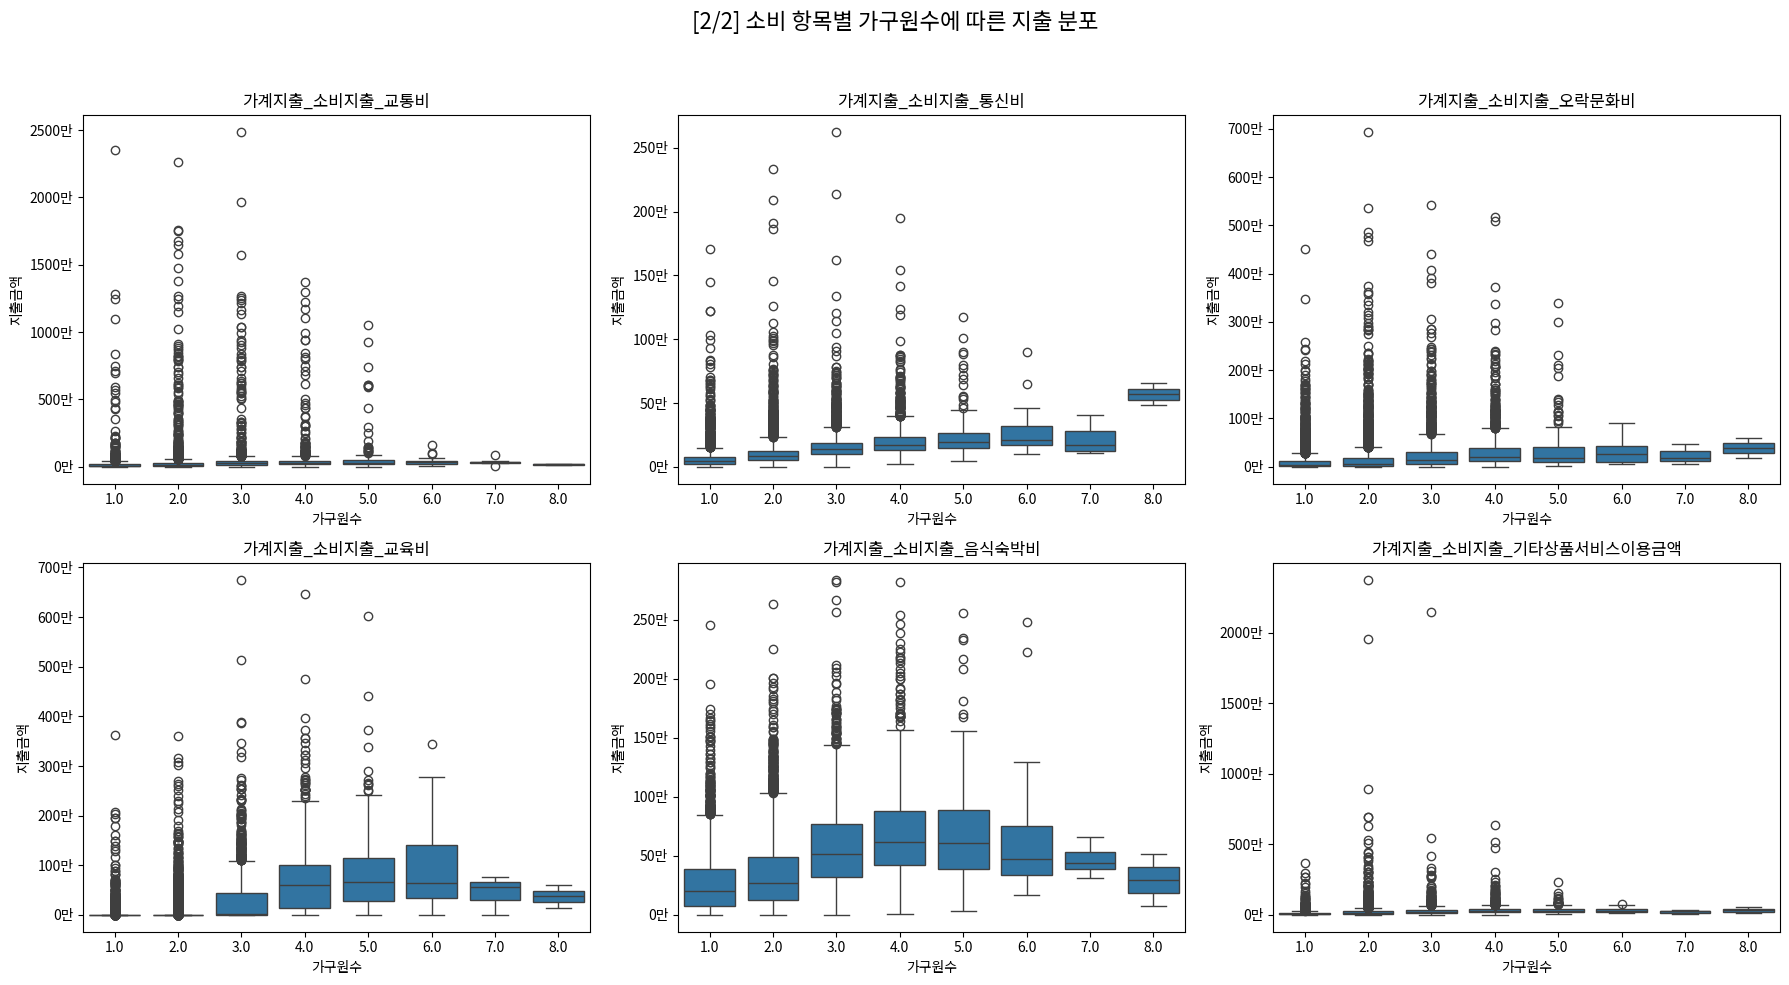

In [82]:
# Boxplot으로 outlier detection

# 첫 번째 6개 항목 (1/2)
fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
axes1 = axes1.flatten()

for i, col in enumerate(item_columns[:6]):
    sns.boxplot(data=df_full, x='가구원수', y=col, ax=axes1[i])
    axes1[i].set_title(f"{col}")
    axes1[i].set_xlabel("가구원수")
    axes1[i].set_ylabel("지출금액")
    # 만원 단위로 포맷
    axes1[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))

plt.suptitle("[1/2] 소비 항목별 가구원수에 따른 지출 분포", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 두 번째 6개 항목 (2/2)
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
axes2 = axes2.flatten()

for i, col in enumerate(item_columns[6:]):
    sns.boxplot(data=df_full, x='가구원수', y=col, ax=axes2[i])
    axes2[i].set_title(f"{col}")
    axes2[i].set_xlabel("가구원수")
    axes2[i].set_ylabel("지출금액")
    # 만원 단위로 포맷
    axes2[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))

plt.suptitle("[2/2] 소비 항목별 가구원수에 따른 지출 분포", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

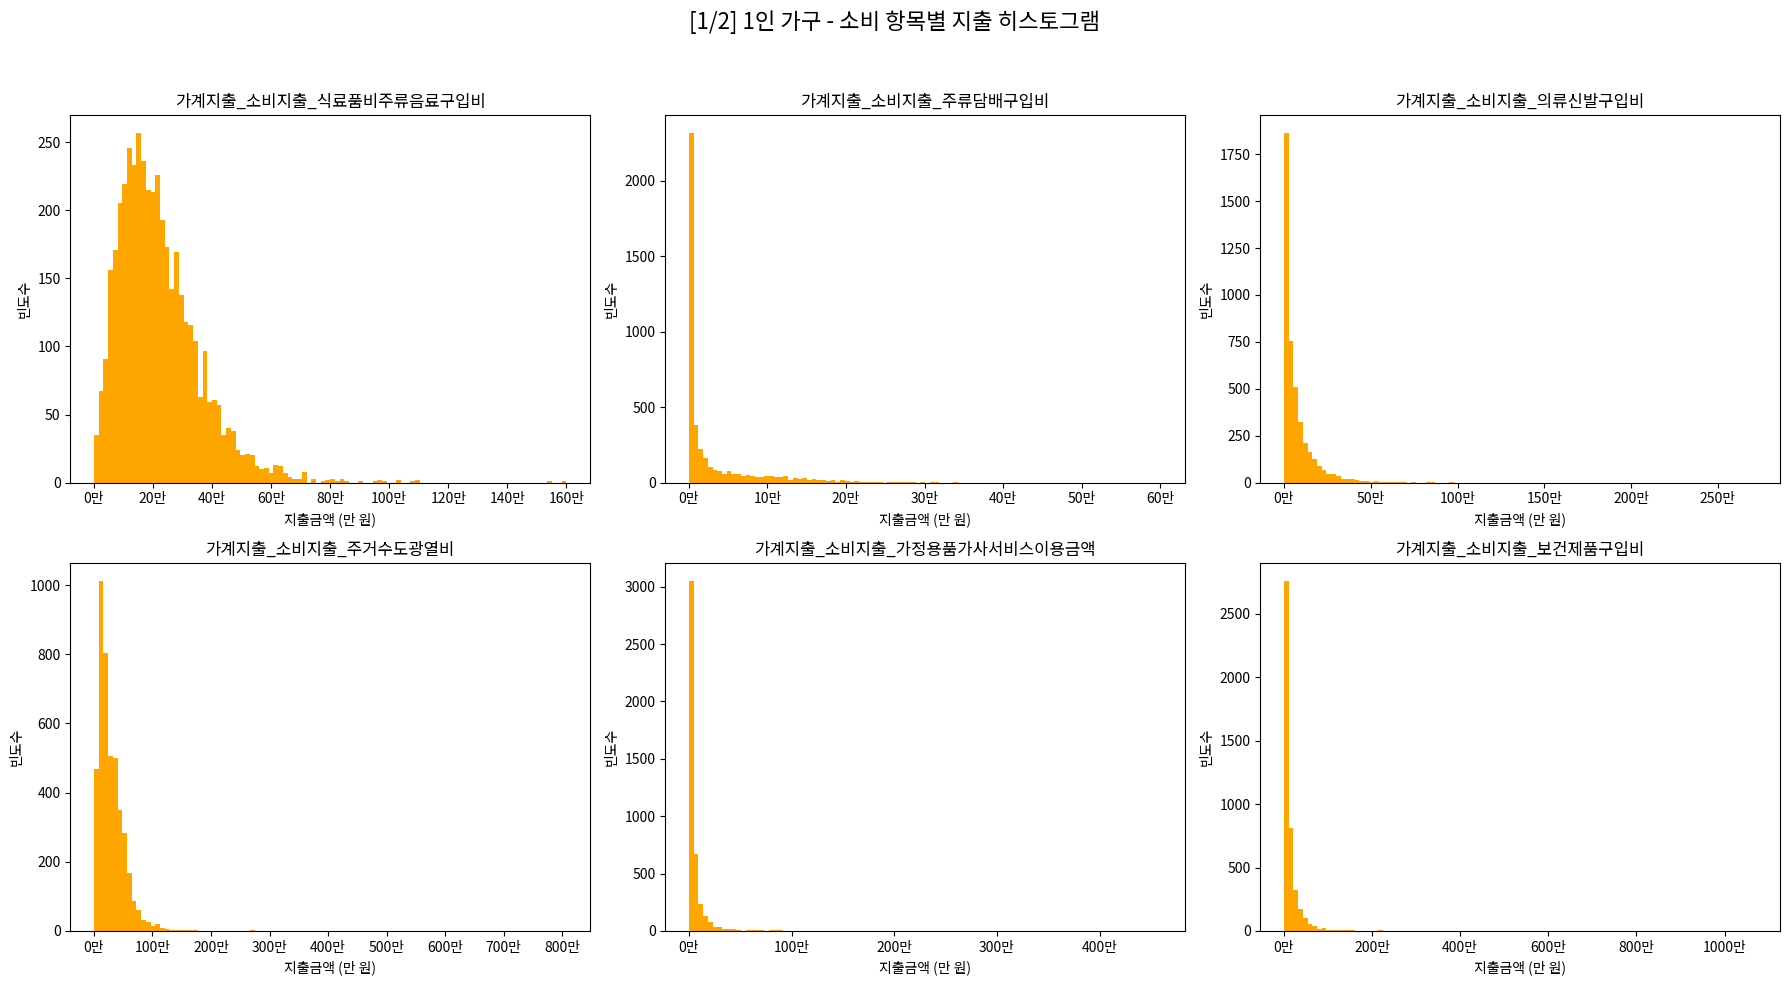

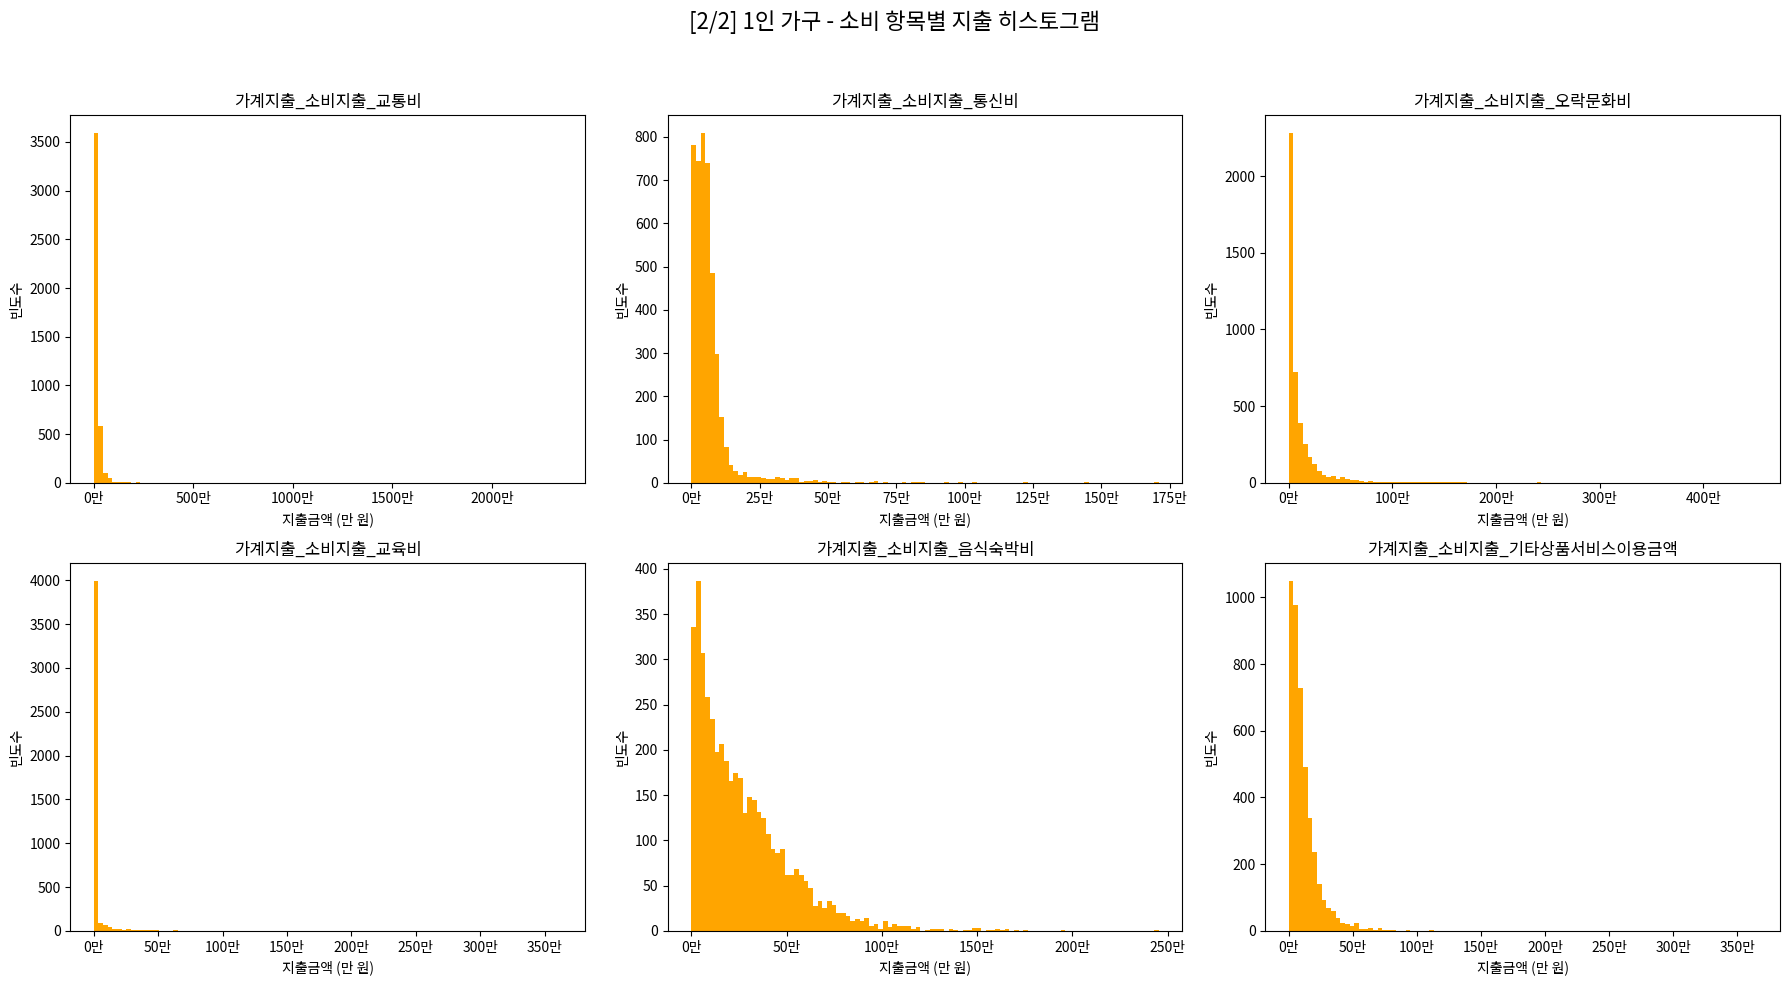

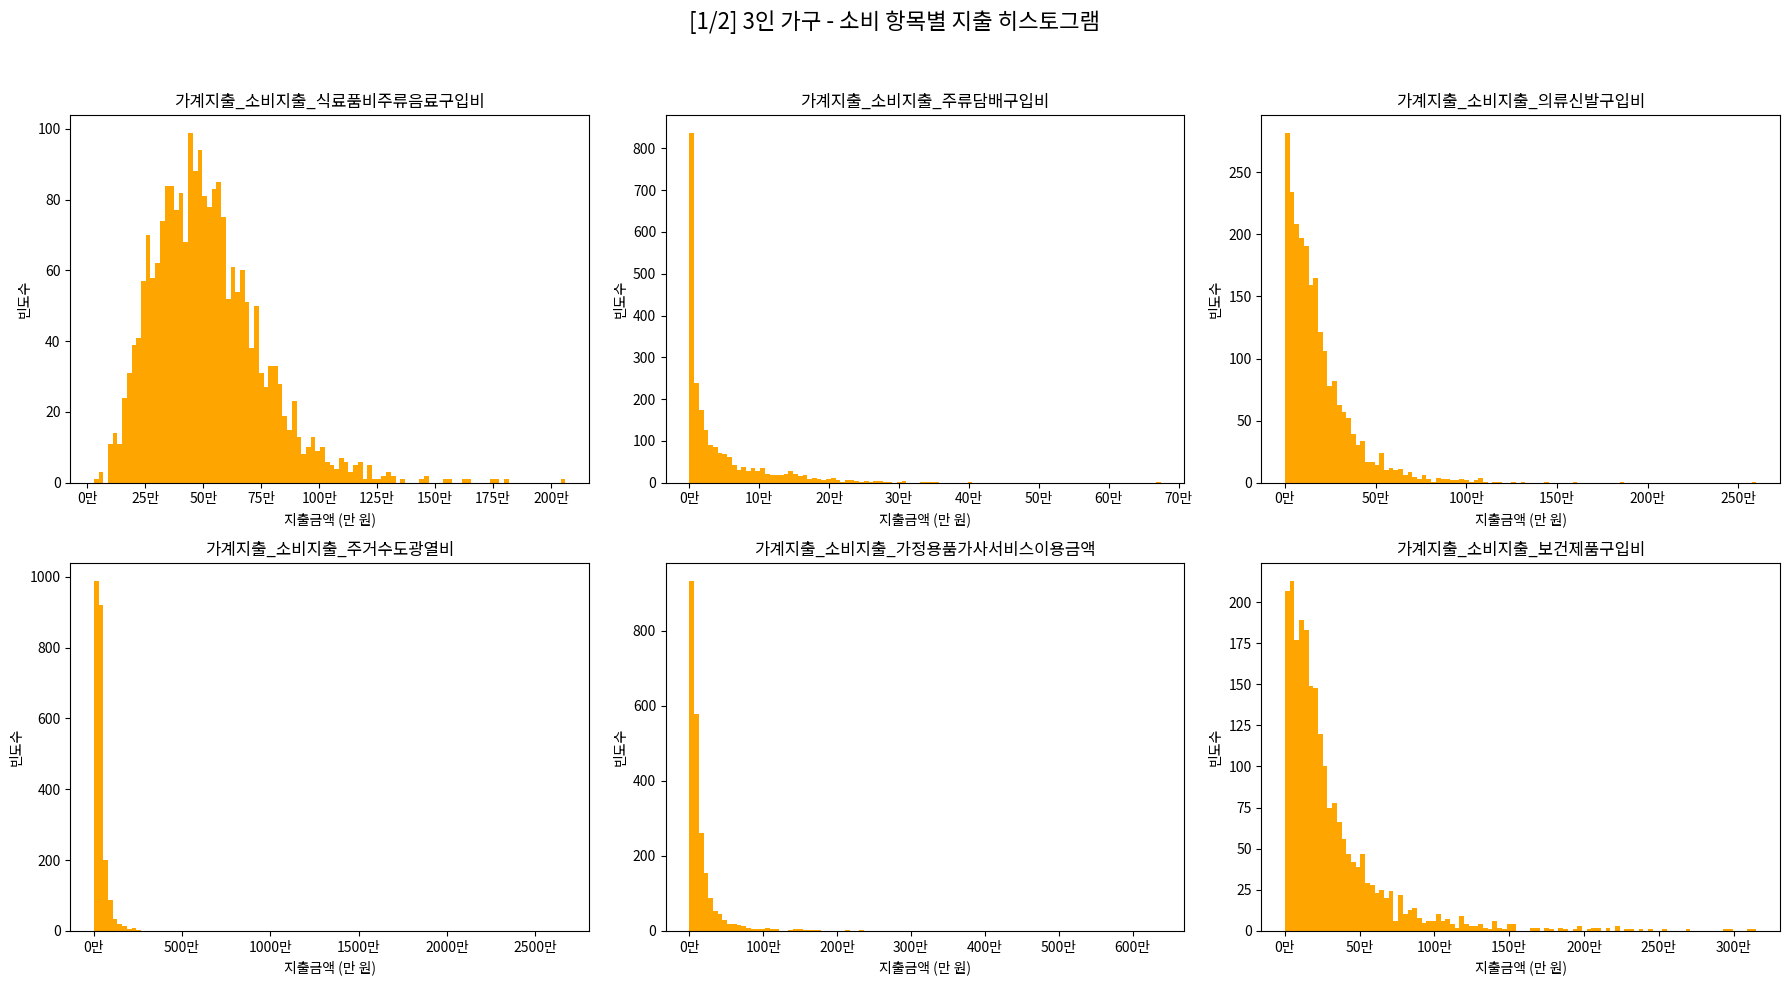

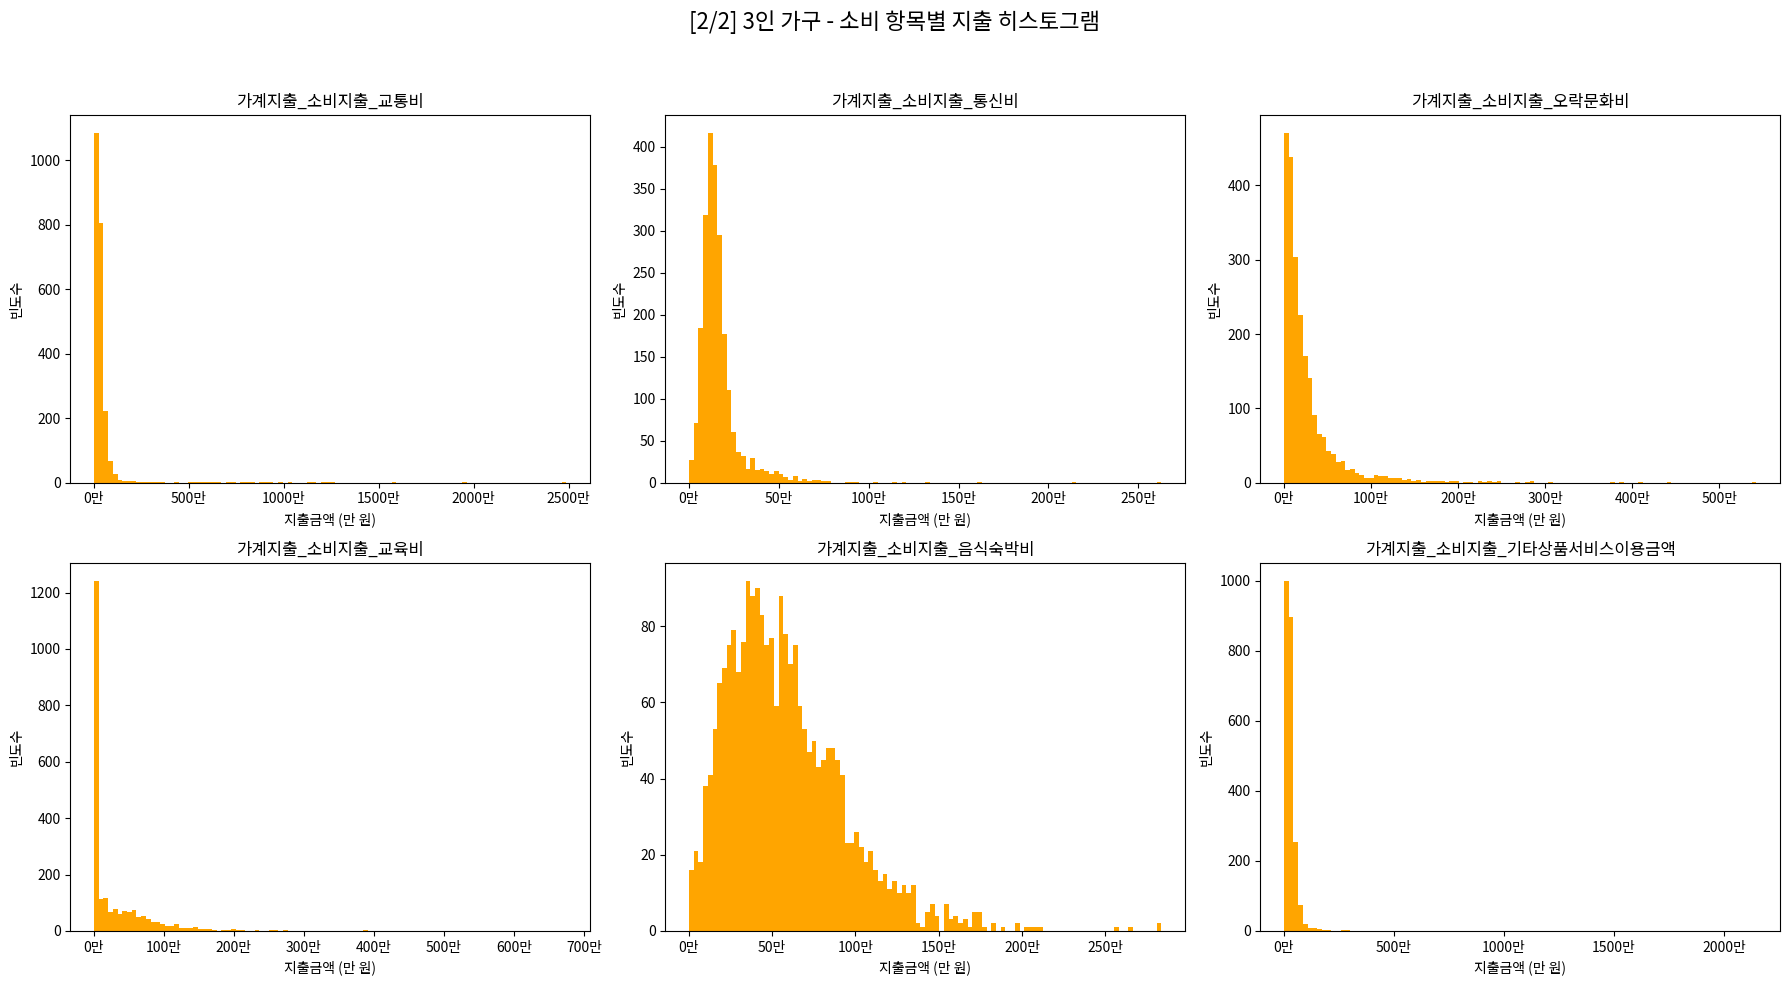

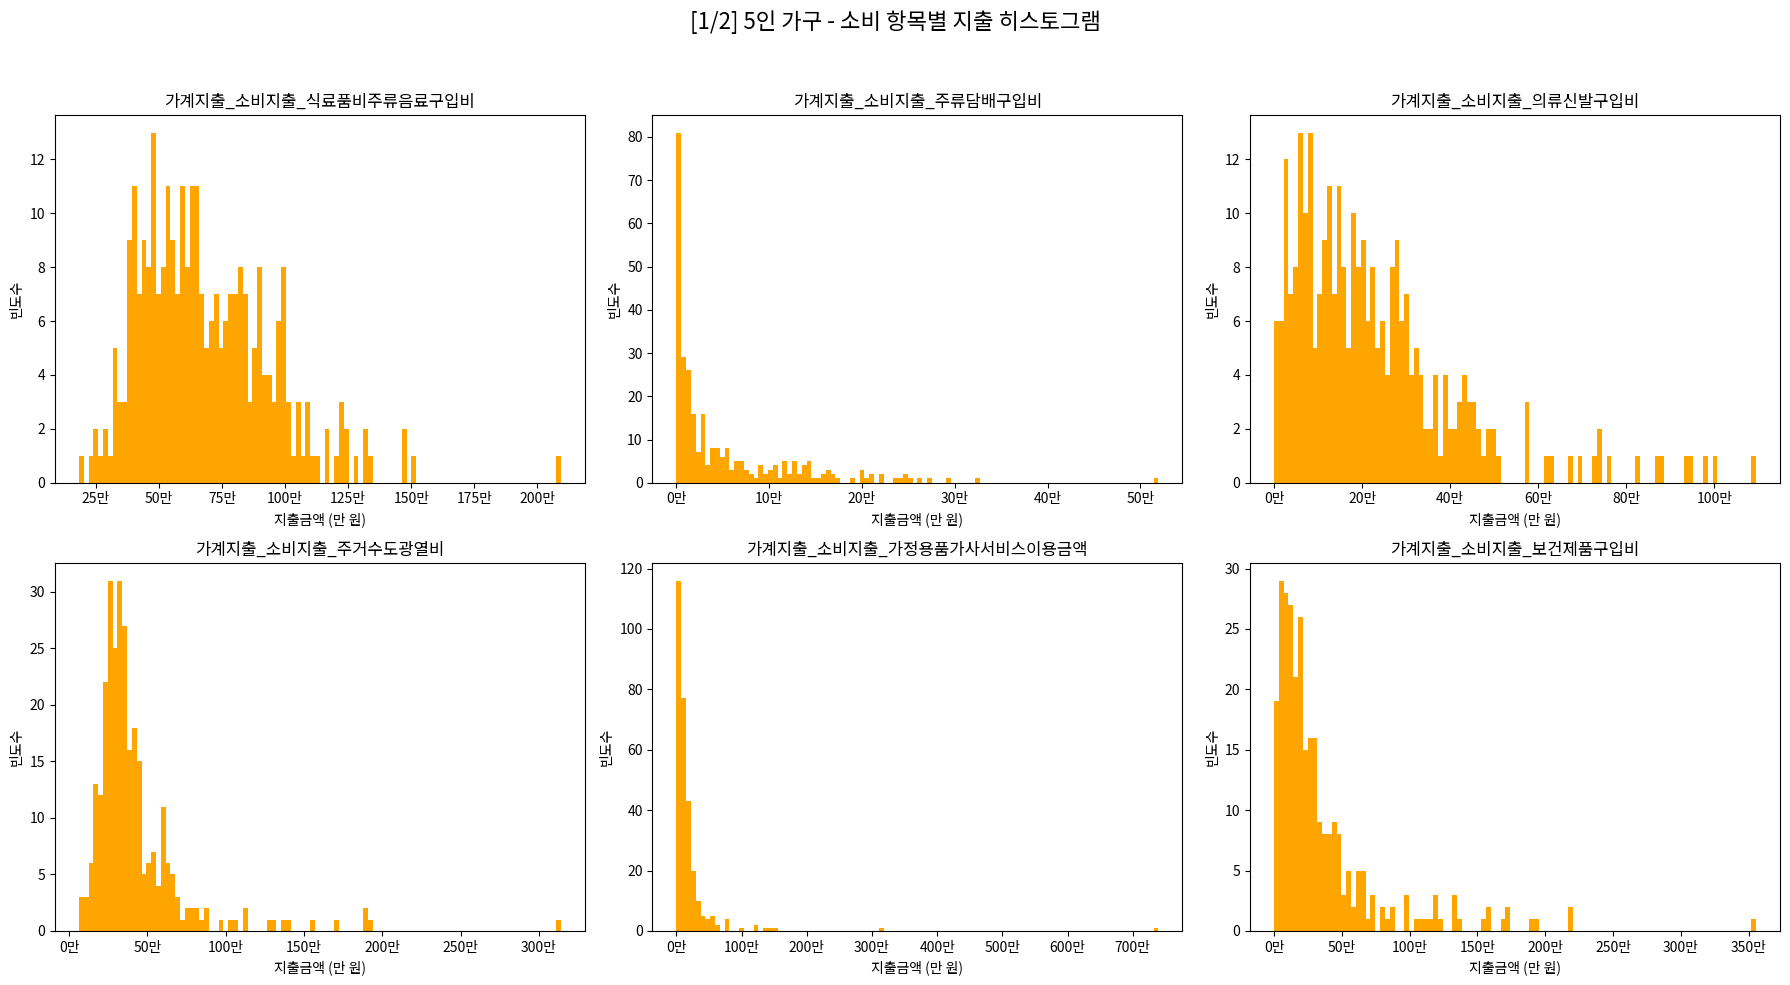

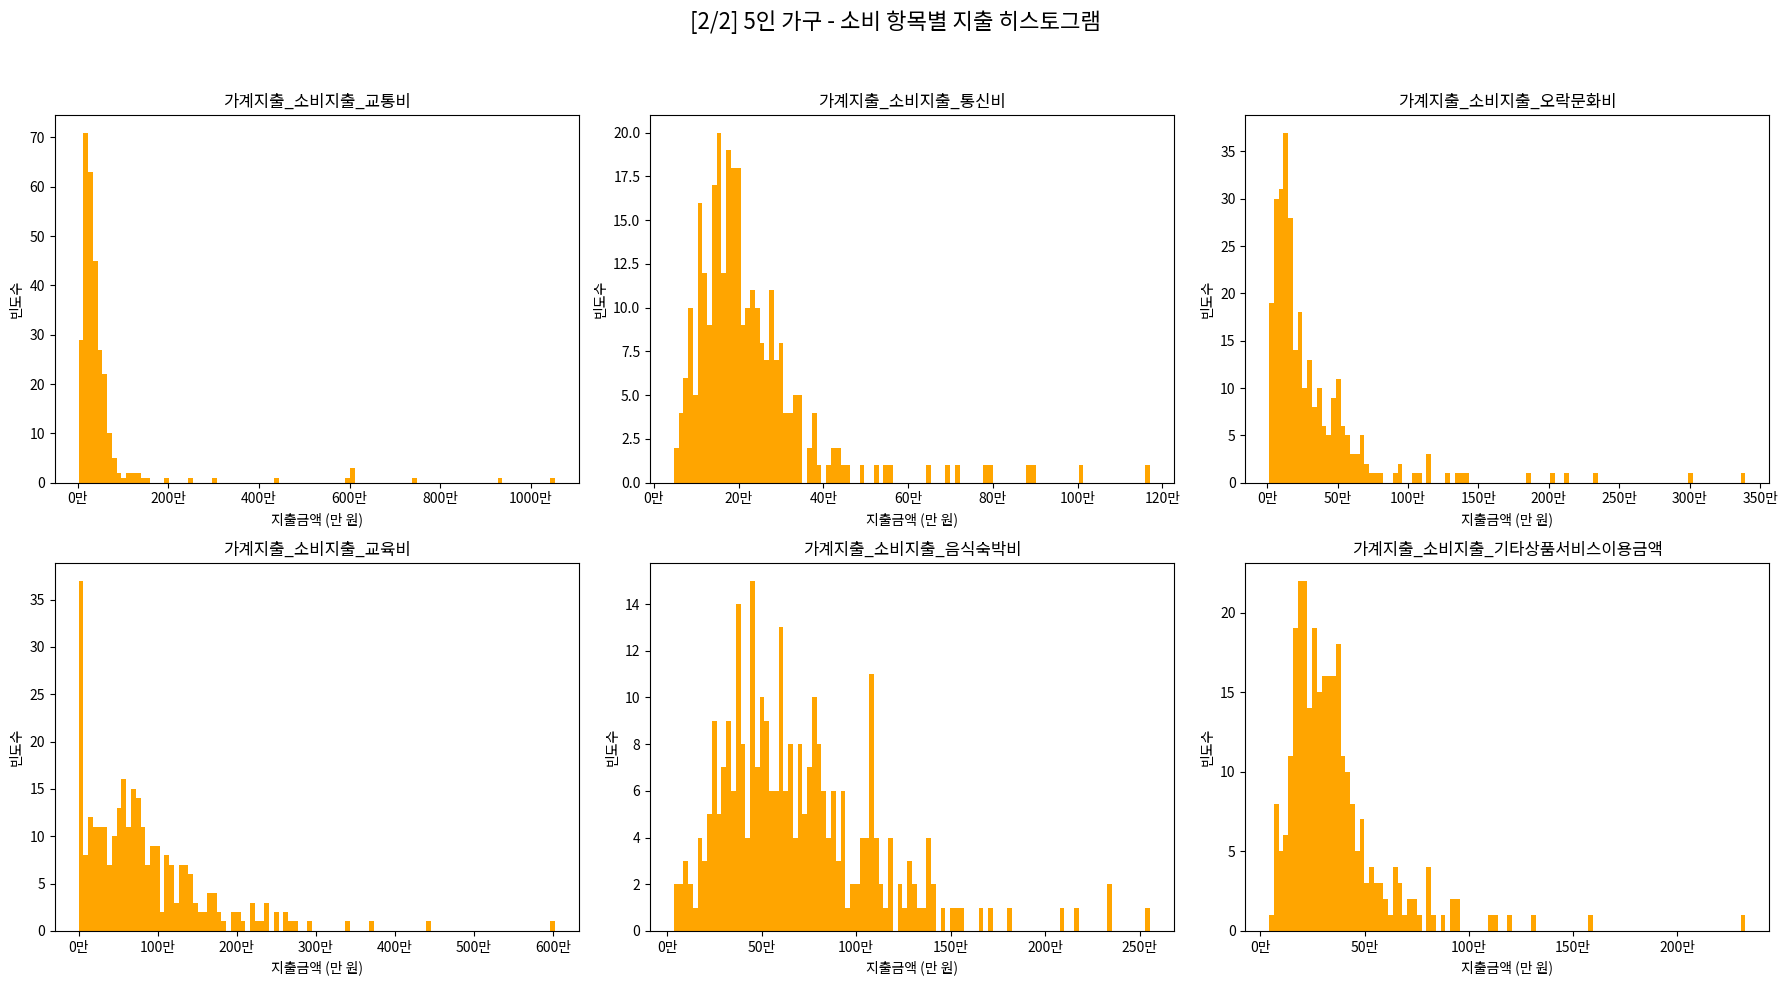

In [83]:
# Histogram

# 소비 항목 리스트
item_columns = [
    '가계지출_소비지출_식료품비주류음료구입비',
    '가계지출_소비지출_주류담배구입비',
    '가계지출_소비지출_의류신발구입비',
    '가계지출_소비지출_주거수도광열비',
    '가계지출_소비지출_가정용품가사서비스이용금액',
    '가계지출_소비지출_보건제품구입비',
    '가계지출_소비지출_교통비',
    '가계지출_소비지출_통신비',
    '가계지출_소비지출_오락문화비',
    '가계지출_소비지출_교육비',
    '가계지출_소비지출_음식숙박비',
    '가계지출_소비지출_기타상품서비스이용금액'
]

# 전체 가구원수에 대해 하면 histogram이 너무 많아지니 대략적으로 알 수 있게 1, 3, 5인으로만 진행. -> 모두 right-skewed의 성질을 가지는 것을 알 수 있음.
target_sizes = [1, 3, 5]


for size in target_sizes:
    subset = df_full[df_full['가구원수'] == size]

    # 첫 번째 6개 항목
    fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
    axes1 = axes1.flatten()
    for i, col in enumerate(item_columns[:6]):
        axes1[i].hist(subset[col].dropna(), bins=100, color='orange')
        axes1[i].set_title(col)
        axes1[i].set_xlabel("지출금액 (만 원)")
        axes1[i].set_ylabel("빈도수")
        axes1[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))
    plt.suptitle(f"[1/2] {size}인 가구 - 소비 항목별 지출 히스토그램", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # 두 번째 6개 항목
    fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
    axes2 = axes2.flatten()
    for i, col in enumerate(item_columns[6:]):
        axes2[i].hist(subset[col].dropna(), bins=100, color='orange')
        axes2[i].set_title(col)
        axes2[i].set_xlabel("지출금액 (만 원)")
        axes2[i].set_ylabel("빈도수")
        axes2[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))
    plt.suptitle(f"[2/2] {size}인 가구 - 소비 항목별 지출 히스토그램", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [84]:
# 가구원수별로 각 항목당 outlier 몇개 있는지 알아보는 코드.
# 결과 저장
outlier_summary = []

# 각 가구원수에 대해
for size, group in df_full.groupby('가구원수'):
    for col in item_columns:
        q1 = group[col].quantile(0.25)
        q3 = group[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        outliers = group[(group[col] < lower) | (group[col] > upper)]
        outlier_summary.append({
            '가구원수': int(size),
            '항목': col,
            '이상치수': len(outliers),
            '총샘플수': len(group),
            '비율(%)': round(len(outliers) / len(group) * 100, 2)
        })

# 데이터프레임 변환
outlier_df = pd.DataFrame(outlier_summary)

# 정렬
outlier_df = outlier_df.sort_values(by=['가구원수', '이상치수'], ascending=[True, False])

# 이상치 요약
outlier_df


,가구원수,항목,이상치수,총샘플수,비율(%)
9,1,가계지출_소비지출_교육비,582,4374,13.31
1,1,가계지출_소비지출_주류담배구입비,576,4374,13.17
4,1,가계지출_소비지출_가정용품가사서비스이용금액,448,4374,10.24
8,1,가계지출_소비지출_오락문화비,429,4374,9.81
5,1,가계지출_소비지출_보건제품구입비,401,4374,9.17
...,...,...,...,...,...
91,8,가계지출_소비지출_통신비,0,2,0.00
92,8,가계지출_소비지출_오락문화비,0,2,0.00
93,8,가계지출_소비지출_교육비,0,2,0.00
94,8,가계지출_소비지출_음식숙박비,0,2,0.00


In [85]:
# outlier 처리
# 가구원수별로 그룹핑하고 너무 극단적으로 큰 값은 clipping 해주고, 전체에 log scaling. (log scaling은 그룹별로 안 해줘도 결과 똑같음.)
# Step 1: 가구원수별로 99.5% quantile 기준으로 clip
for col in item_columns:
    for size, group in df_full.groupby('가구원수'):
        threshold = group[col].quantile(0.995)
        mask = df_full['가구원수'] == size
        df_full.loc[mask, col] = df_full.loc[mask, col].clip(upper=threshold)


for col in item_columns:
    negative_values = df_full[df_full[col] < 0][col]
    if not negative_values.empty:
        print(f"컬럼 '{col}'에서 발견된 음수 값들:\n{negative_values.describe()}\n")
        
# Step 2: log1p 변환해서 "_log" 컬럼 추가
for col in item_columns:
    df_full[col + '_log'] = np.log1p(df_full[col])


# 결과와 확인하기 위해 12가지 소비 품목의 max값 각각 출력해보기.
print("\n클리핑 및 로그변환 후 원본 item_columns의 max값 (확인용):")
print(df_full[item_columns].max())


클리핑 및 로그변환 후 원본 item_columns의 max값 (확인용):
가계지출_소비지출_식료품비주류음료구입비      1550443.140
가계지출_소비지출_주류담배구입비           311189.805
가계지출_소비지출_의류신발구입비          1349508.945
가계지출_소비지출_주거수도광열비          2213982.630
가계지출_소비지출_가정용품가사서비스이용금액    2406008.280
가계지출_소비지출_보건제품구입비          3274055.500
가계지출_소비지출_교통비              9726700.800
가계지출_소비지출_통신비               957314.425
가계지출_소비지출_오락문화비            2682749.075
가계지출_소비지출_교육비              4088130.635
가계지출_소비지출_음식숙박비            2445591.240
가계지출_소비지출_기타상품서비스이용금액      2364572.460
dtype: float64


In [86]:
# Feature creation
# 가구원수가 다르면 소비 금액이 달라지는 게 당연하므로, 소비 품목 / 소비지출로 비율 구해서 새로운 열로 추가.
# 총 소비지출금액
total_column = '가계지출_소비지출금액'

# 각 항목의 비율 계산
for col in item_columns:
    ratio_col = col + '_비율'
    df_full[ratio_col] = df_full[col] / (df_full[total_column] + 1e-5)  # 0 나누기 방지용 작은 수 추가

df_full.to_csv('ratio.csv')

# Encoding

In [87]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. 산업 코드 대분류 그룹화 함수 정의
def map_industry_group(code):
    if code in ['A']:
        return '1차산업'
    elif code in ['B', 'C', 'D', 'E', 'F']:
        return '제조건설업'
    elif code in ['G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']:
        return '서비스업'
    elif code in ['O', 'P', 'Q']:
        return '공공/교육/보건'
    else:
        return '기타'

dataset['산업_대분류'] = dataset['가구주_10차산업분류코드'].map(map_industry_group)

# 1. 인코딩할 범주형 컬럼 지정
categorical_features = [
    '가구구분코드',
    '가구주_취업여부',
    '거처구분코드',
    '입주형태코드',
    '산업_대분류'  # ← 앞서 그룹화한 것
]

# 2. 인코더 설정. 다중공선성을 제거하기 위해 기준값 하나 제거.
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# 3. 변환 실행
encoded_array = ohe.fit_transform(dataset[categorical_features])

# 4. 인코딩된 feature 이름 가져오기
encoded_feature_names = ohe.get_feature_names_out(categorical_features)

# 5. DataFrame으로 변환
encoded_df = pd.DataFrame(encoded_array, columns=encoded_feature_names, index=dataset.index)

# 6. 원래 dataset에서 범주형 열 제거 후 인코딩된 열 붙이기
dataset = pd.concat([dataset.drop(columns=categorical_features), encoded_df], axis=1)

# 결과 확인
dataset.to_csv('after_encoded.csv')